In [1]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
import numpy as np

In [2]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
# a @ b is equivalent to np.matmul(a, b)
c_mm_relu = np.maximum(a_np @ b_np, 0)

### a lower level numpy


In [3]:
def lnumpy_mm_relu(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j in range(128):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
    for i in range(128):
        for j in range(128):
            C[i, j] = max(Y[i, j], 0)

In [4]:
c_np = np.empty((128, 128), dtype=dtype)
lnumpy_mm_relu(a_np, b_np, c_np)
np.testing.assert_allclose(c_mm_relu, c_np, rtol=1e-5)

In [5]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"],
                B: T.Buffer[(128, 128), "float32"],
                C: T.Buffer[(128, 128), "float32"]):
        T.func_attr({"global_symbol": "mm_relu", "tir.noalias": True})
        Y = T.alloc_buffer((128, 128), dtype="float32")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                vk = T.axis.reduce(128, k)
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [6]:
def lnumpy_mm_relu_v2(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j0 in range(32):
            for k in range(128):
                for j1 in range(4):
                    j = j0 * 4 + j1
                    if k == 0:
                        Y[i, j] = 0
                    Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
    for i in range(128):
        for j in range(128):
            C[i, j] = max(Y[i, j], 0)

c_np = np.empty((128, 128), dtype=dtype)
lnumpy_mm_relu_v2(a_np, b_np, c_np)
np.testing.assert_allclose(c_mm_relu, c_np, rtol=1e-5)

In [7]:
import IPython

IPython.display.Code(MyModule.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(A[vi, vk], B[vk, vj])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj])
                T.writes(C[vi, vj])
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [8]:
sch = tvm.tir.Schedule(MyModule)

In [9]:
block_Y = sch.get_block("Y", func_name="mm_relu")
i, j, k = sch.get_loops(block_Y)

In [10]:
j0, j1 = sch.split(j, factors=[None, 4])

In [11]:
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0, j_1, k in T.grid(128, 32, 4, 128):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j_0 * 4 + j_1)
                vk = T.axis.reduce(128, k)
                T.reads(A[vi, vk], B[vk, vj])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj])
                T.writes(C[vi, vj])
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [12]:
sch.reorder(j0, k, j1)
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0, k, j_1 in T.grid(128, 32, 128, 4):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j_0 * 4 + j_1)
                vk = T.axis.reduce(128, k)
                T.reads(A[vi, vk], B[vk, vj])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj])
                T.writes(C[vi, vj])
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

## 算子融合

In [13]:
block_C = sch.get_block("C", "mm_relu")
sch.reverse_compute_at(block_C, j0)
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0 in T.grid(128, 32):
            for k, j_1 in T.grid(128, 4):
                with T.block("Y"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1)
                    vk = T.axis.reduce(128, k)
                    T.reads(A[vi, vk], B[vk, vj])
                    T.writes(Y[vi, vj])
                    with T.init():
                        Y[vi, vj] = T.float32(0)
                    Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
            for ax0 in T.serial(4):
                with T.block("C"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + ax0)
                    T.reads(Y[vi, vj])
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [14]:
sch.decompose_reduction(block_Y, k)
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import tir as T
@tvm.script.ir_module
class Module:
    @T.prim_func
    def mm_relu(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "mm_relu"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([128, 128], dtype="float32")
        for i, j_0 in T.grid(128, 32):
            for j_1_init in T.serial(4):
                with T.block("Y_init"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1_init)
                    T.reads()
                    T.writes(Y[vi, vj])
                    Y[vi, vj] = T.float32(0)
            for k, j_1 in T.grid(128, 4):
                with T.block("Y_update"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1)
                    vk = T.axis.reduce(128, k)
                    T.reads(Y[vi, vj], A[vi, vk], B[vk, vj])
                    T.writes(Y[vi, vj])
                    Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
            for ax0 in T.serial(4):
                with T.block("C"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + ax0)
                    T.reads(Y[vi, vj])
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

In [15]:
rt_lib = tvm.build(MyModule, target="llvm")

In [16]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")
type(c_nd)

tvm.runtime.ndarray.NDArray

In [17]:
func_mm_relu = rt_lib["mm_relu"]
func_mm_relu(a_nd, b_nd, c_nd)

np.testing.assert_allclose(c_mm_relu, c_nd.numpy(), rtol=1e-5)

In [18]:
rt_lib_after = tvm.build(sch.mod, target="llvm")
rt_lib_after["mm_relu"](a_nd, b_nd, c_nd)
np.testing.assert_allclose(c_mm_relu, c_nd.numpy(), rtol=1e-5)

In [19]:
f_timer_before = rt_lib.time_evaluator("mm_relu", tvm.cpu())
print("Time cost of MyModule %g sec" % f_timer_before(a_nd, b_nd, c_nd).mean)
f_timer_after = rt_lib_after.time_evaluator("mm_relu", tvm.cpu())
print("Time cost of transformed sch.mod %g sec" % f_timer_after(a_nd, b_nd, c_nd).mean)

Time cost of MyModule 0.00262603 sec
Time cost of transformed sch.mod 0.000406929 sec


In [20]:
def transform(mod, jfactor):
    sch = tvm.tir.Schedule(mod)
    block_Y = sch.get_block("Y", func_name="mm_relu")
    i, j, k = sch.get_loops(block_Y)
    j0, j1 = sch.split(j, factors=[None, jfactor])
    sch.reorder(j0, k, j1)
    block_C = sch.get_block("C", "mm_relu")
    sch.reverse_compute_at(block_C, j0)
    return sch.mod

def jfactor_test(j):
    mod_transformed = transform(MyModule, jfactor=j)

    rt_lib_transformed = tvm.build(mod_transformed, "llvm")
    f_timer_transformed = rt_lib_transformed.time_evaluator("mm_relu", tvm.cpu())
    print("Time cost of transformed mod_transformed %g sec" % f_timer_transformed(a_nd, b_nd, c_nd).mean)
    # display the code below
    # print(f_timer_transformed(a_nd, b_nd, c_nd).mean)
    IPython.display.Code(mod_transformed.script(), language="python")
    return f_timer_transformed(a_nd, b_nd, c_nd).mean

In [28]:
result = []
xpoints = []
for j in range(1,200):
    xpoints.append(j)
    result.append(jfactor_test(j))
print(result)

Time cost of transformed mod_transformed 0.00448128 sec
Time cost of transformed mod_transformed 0.000850929 sec
Time cost of transformed mod_transformed 0.0006496 sec
Time cost of transformed mod_transformed 0.000452954 sec
Time cost of transformed mod_transformed 0.000483258 sec
Time cost of transformed mod_transformed 0.000377767 sec
Time cost of transformed mod_transformed 0.000401671 sec
Time cost of transformed mod_transformed 0.000216217 sec
Time cost of transformed mod_transformed 0.000405958 sec
Time cost of transformed mod_transformed 0.000253117 sec
Time cost of transformed mod_transformed 0.000256737 sec
Time cost of transformed mod_transformed 0.000226329 sec
Time cost of transformed mod_transformed 0.000216392 sec
Time cost of transformed mod_transformed 0.000242629 sec
Time cost of transformed mod_transformed 0.000254738 sec
Time cost of transformed mod_transformed 0.000294254 sec
Time cost of transformed mod_transformed 0.00025945 sec
Time cost of transformed mod_transf

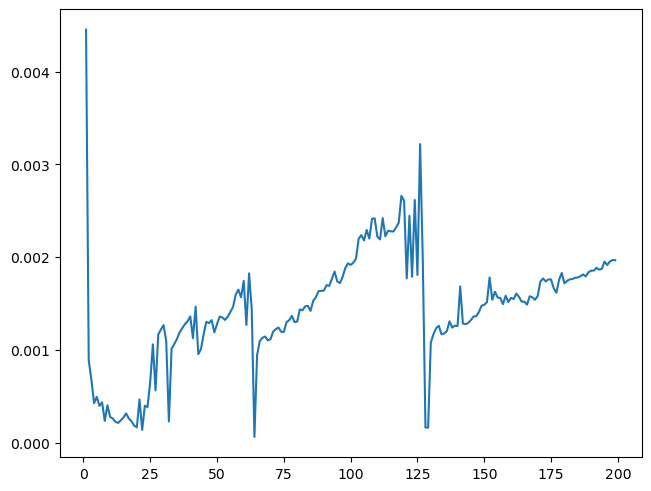

In [44]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(16, 12))
fig, ax0 = plt.subplots(1, 1, sharex=True, constrained_layout=True)
# fig.figsize(15, 15)
ax0.plot(xpoints, result)

# plt.show()
